In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.2.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
Pandas 2.0.0
Scikit-Learn 1.2.2
GPU is available


In [3]:
from tensorflow.keras.datasets import mnist

In [4]:
(x_train,y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


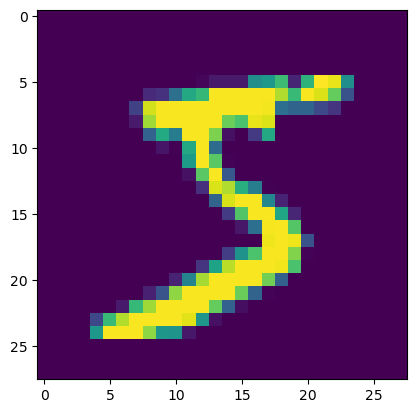

In [5]:
plt.imshow(x_train[0])

In [6]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
single_digit = x_train[y_train==3]

In [12]:
single_digit.shape

(6131, 28, 28)

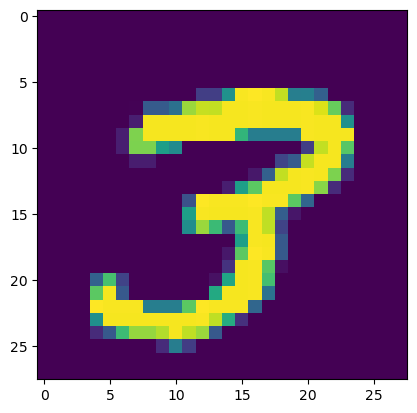

In [13]:
plt.imshow(single_digit[19])

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential

In [9]:
def reshape_img_dcgan(train,largest_val):
    print(f" The original min = {train.min()}")
    train = train/largest_val
    train = train.reshape(-1,28,28,1)*2. -1.
    print(f" The new min = {train.min()}")
    return train.copy()

In [10]:
def get_my_data(n:int):
    (x_train,y_train),(x_test, y_test) = mnist.load_data()
    x_train = reshape_img_dcgan(x_train,255)
    return x_train[y_train == n]


In [11]:
my_data = get_my_data(3)

 The original min = 0
 The new min = -1.0


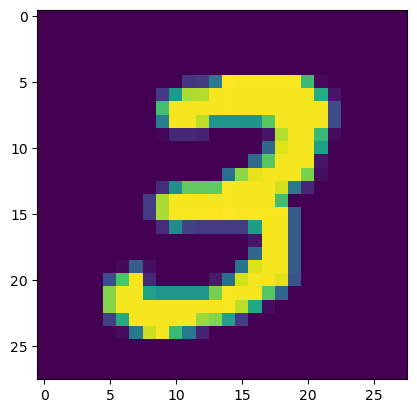

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100
kernel_size = 5

In [13]:
def get_generator(codings_sizen,kernel_size):
    generator = Sequential()
    generator.add(Dense(7 * 7 * 128,input_shape=[codings_size]))
    generator.add(Reshape([7,7,128]))
    generator.add(BatchNormalization())
    generator.add(Conv2DTranspose(64, kernel_size = kernel_size,strides = 2, padding = 'same',activation = 'relu'))
    generator.add(BatchNormalization())
    generator.add(Dense(100,activation='relu'))
    generator.add(Dense(784,activation='relu'))
    generator.add(Conv2DTranspose(1, kernel_size = kernel_size,strides = 2, padding = 'same',activation = 'tanh'))
    return generator
   

In [14]:
def get_discriminator(codings_size,kernel_size):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size = kernel_size,strides = 2, padding = 'same'
                             ,activation = LeakyReLU(0.3)
                            , input_shape = [28,28,1]))
    
    discriminator.add(Dropout(0.5))
    discriminator.add(Conv2D(128, kernel_size = kernel_size,strides = 2, padding = 'same'
                             ,activation = LeakyReLU(0.3)))
    discriminator.add(Dropout(0.5))
    discriminator.add(Flatten())
    discriminator.add(Dense(1,activation='sigmoid'))
    return discriminator

In [15]:
def get_dcgan(generator,discriminator):
    return Sequential([generator,discriminator])

In [16]:
generator = get_generator(codings_size,kernel_size)
discriminator = get_discriminator(codings_size,kernel_size)
GAN = get_dcgan(generator,discriminator)

Metal device set to: Apple M2 Pro


In [17]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False
GAN.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [41]:
batch_size = 32
my_data = my_data
epochs=10

In [19]:
my_data.shape

(6131, 28, 28, 1)

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [21]:
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

In [22]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [23]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

In [42]:
def train_dcgan():
    generator, discriminator = GAN.layers

    for epoch in range(epochs):
        print(f"currently on epoch = {epoch+1}")
        i = 0
        for x_batch in dataset:
            i = i+1
            if i%20 == 0:
                print(f"\t currently on batch number {i} of {len(my_data)//batch_size}")

            # Discriminator
            noise = tf.random.normal(shape=[batch_size,codings_size])
            gen_images = generator(noise)
            x_fake_vs_real = tf.concat([gen_images,tf.dtypes.cast(x_batch,tf.float32)],axis=0)
            y1 = tf.constant([[0.0]]*batch_size + [[1.0]]*batch_size)
            discriminator.trainable = True

            discriminator.train_on_batch(x_fake_vs_real,y1)

            # Train Generator
            noise = tf.random.normal(shape=[batch_size,codings_size])
            y2 = tf.constant([[1.0]]*batch_size)
            discriminator.trainable = False

            GAN.train_on_batch(noise,y2)
    return GAN
## Generator soon learns a pattern that always fools the discriminator and keeps repeating the pattern
## one way to get out of this is to maintain a replay buffer and drop images that are already generated
        
    

In [43]:
GAN = train_dcgan()

currently on epoch = 1
	 currently on batch number 20 of 191
	 currently on batch number 40 of 191
	 currently on batch number 60 of 191
	 currently on batch number 80 of 191
	 currently on batch number 100 of 191
	 currently on batch number 120 of 191
	 currently on batch number 140 of 191
	 currently on batch number 160 of 191
	 currently on batch number 180 of 191
currently on epoch = 2
	 currently on batch number 20 of 191
	 currently on batch number 40 of 191
	 currently on batch number 60 of 191
	 currently on batch number 80 of 191
	 currently on batch number 100 of 191
	 currently on batch number 120 of 191
	 currently on batch number 140 of 191
	 currently on batch number 160 of 191
	 currently on batch number 180 of 191
currently on epoch = 3
	 currently on batch number 20 of 191
	 currently on batch number 40 of 191
	 currently on batch number 60 of 191
	 currently on batch number 80 of 191
	 currently on batch number 100 of 191
	 currently on batch number 120 of 191
	 curre

In [46]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [47]:
noise = tf.random.normal(shape=[10,codings_size])

In [48]:
noise.shape

TensorShape([10, 100])

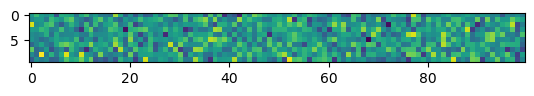

In [49]:
plt.imshow(noise)

In [50]:
images = GAN.layers[0](noise)

In [51]:
images.shape

TensorShape([10, 28, 28, 1])

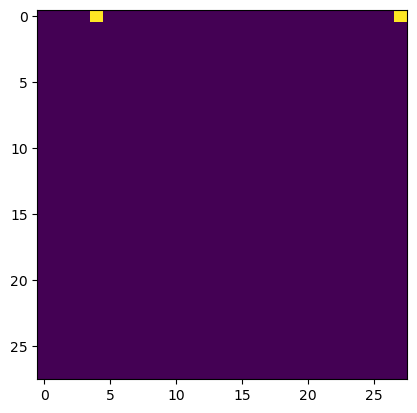

In [52]:
plt.imshow(images[0].numpy().reshape(28,28))

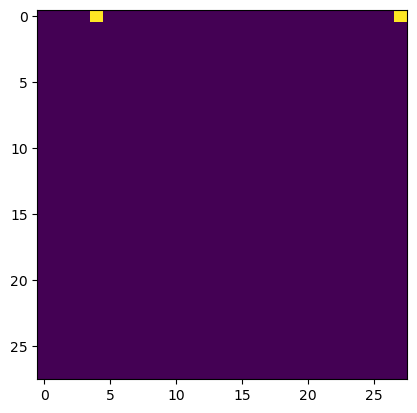

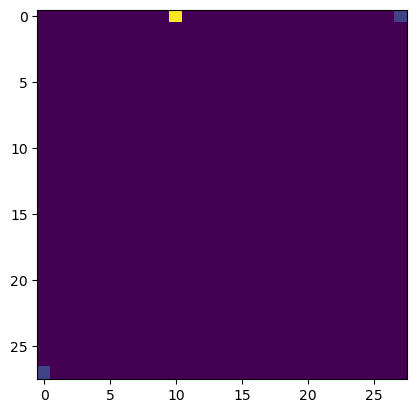

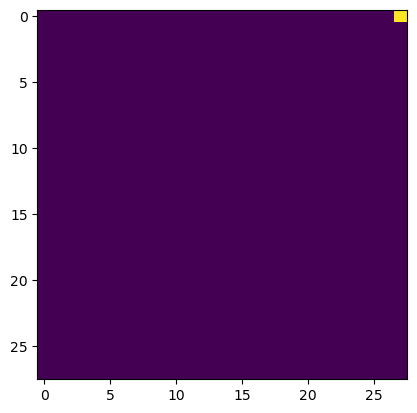

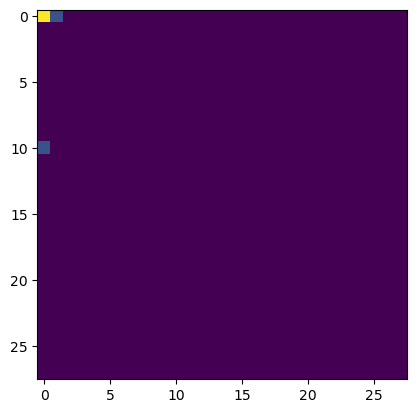

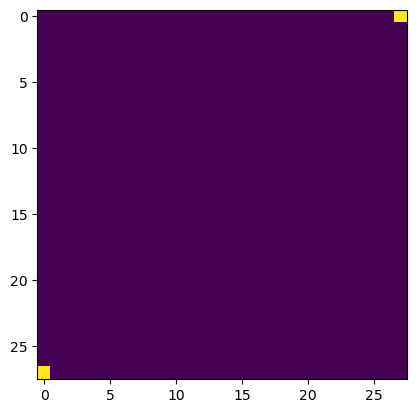

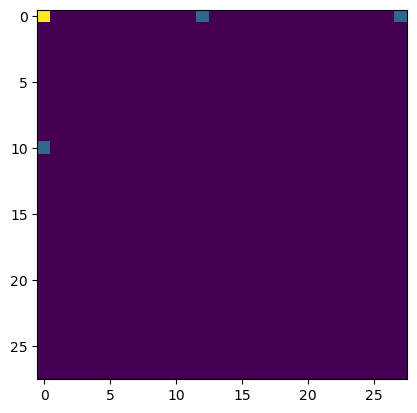

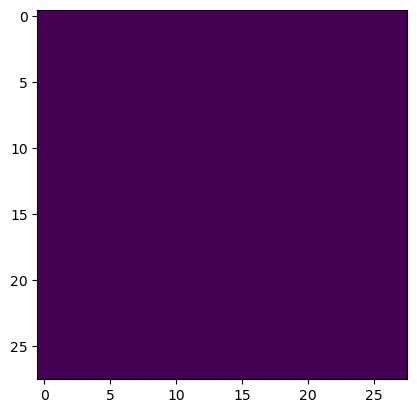

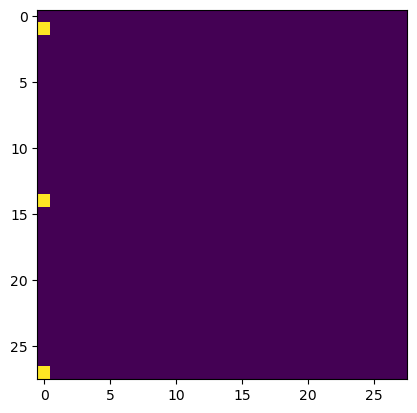

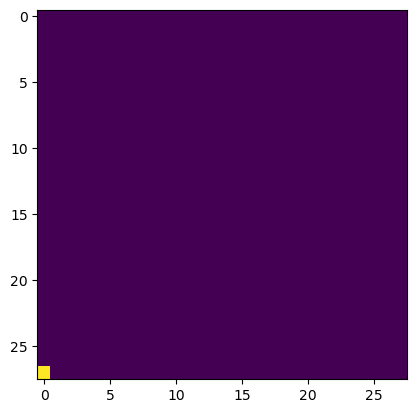

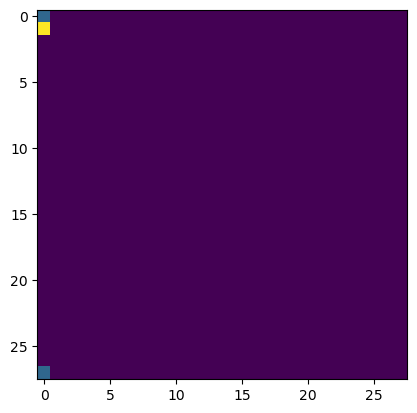

In [53]:
for i in images:
    plt.imshow(i)
    plt.show()

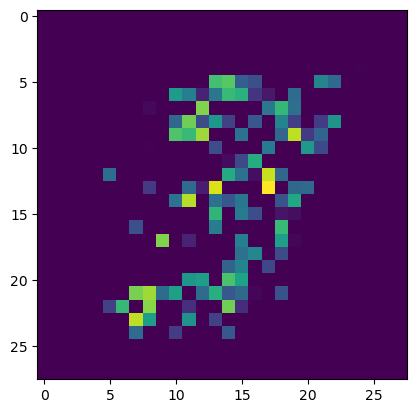

In [126]:
plt.imshow(images[0])

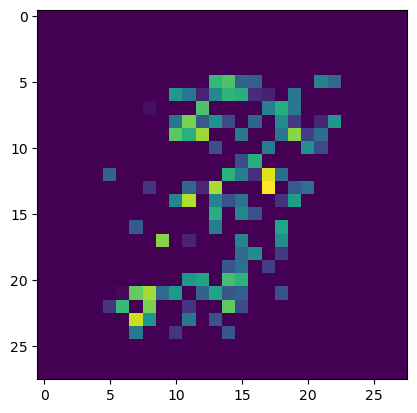

In [127]:
plt.imshow(images[1])

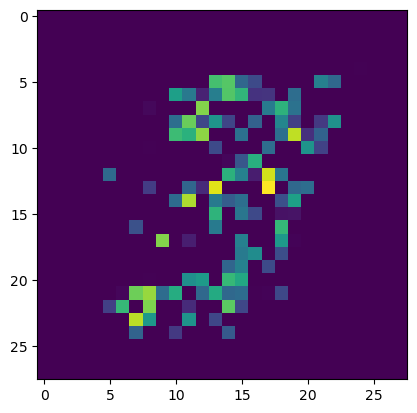

In [128]:
plt.imshow(images[2])

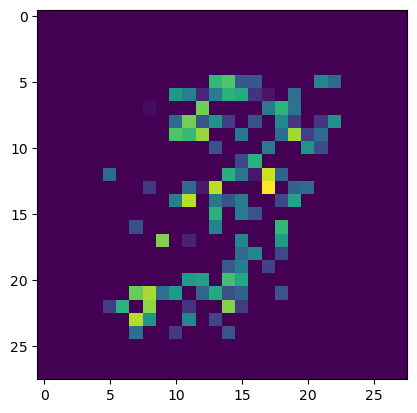

In [129]:
plt.imshow(images[4])